In [275]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [276]:
from IPython.display import display

In [277]:
def generate_PSD(n, singular = False, seed = None):
    if seed is not None:
        np.random.seed(seed)
    # Generate random vectors and orthogonalize them via QR decomposition
    X = np.random.normal(loc=0, scale=1, size=(n, n))
    Q, R = np.linalg.qr(X)
    # Generate random positive eigenvalues
    eigvals = np.sort(np.random.lognormal(mean=1, sigma=1, size=(n,)))
    indices = range(1, n) if singular else range(n)
    # Define a new matrix as a sum of outer products
    M = np.zeros((n, n), dtype='float')
    for i in indices:
        M += eigvals[i] * np.outer(Q[:, i], Q[:, i])
    return M

In [278]:
n = 5
M = generate_PSD(n, singular = True)
M

array([[ 4.35292271,  0.84498811,  0.43932414, -2.23387933, -0.92877447],
       [ 0.84498811,  1.51697161, -0.75894326, -0.7295807 , -0.2042558 ],
       [ 0.43932414, -0.75894326,  0.77831984,  0.1686278 , -0.01364538],
       [-2.23387933, -0.7295807 ,  0.1686278 ,  1.66771805,  0.15200068],
       [-0.92877447, -0.2042558 , -0.01364538,  0.15200068,  0.85848309]])

In [279]:
target_evals, target_evecs = np.linalg.eigh(M)
display(target_evals.round(4))
display(target_evecs.round(4))

array([-0.    ,  0.2905,  0.8765,  1.9563,  6.0512])

array([[-0.4418, -0.193 , -0.0622,  0.2626, -0.8335],
       [ 0.2658, -0.546 , -0.1687, -0.74  , -0.235 ],
       [ 0.6133, -0.515 ,  0.0446,  0.5968, -0.0211],
       [-0.5088, -0.496 , -0.5029,  0.1489,  0.469 ],
       [-0.3149, -0.3916,  0.8443, -0.0713,  0.1721]])

In [280]:
eps = 1e-3

In [281]:
Z = np.linalg.inv(M + eps * np.identity(M.shape[0])) - 1/eps * np.outer(target_evecs[:,0], target_evecs[:,0])

In [282]:
pd.DataFrame(Z)

,0,1,2,3,4
0,0.282284,0.306637,0.420923,0.319568,0.166216
1,0.306637,1.344066,0.731383,0.951388,0.591518
2,0.420923,0.731383,1.094394,0.894753,0.712499
3,0.319568,0.951388,0.894753,1.180107,0.190516
4,0.166216,0.591518,0.712499,0.190516,1.345930


In [283]:
evals, evecs = np.linalg.eigh(Z)
evals, evecs

(array([ -2.83023339e-10,   1.65230077e-01,   5.10905013e-01,
          1.13962886e+00,   3.43101712e+00]),
 array([[ 0.4417989 ,  0.83348848,  0.26263732, -0.06221487,  0.19303276],
        [-0.26581003,  0.23502663, -0.73997188, -0.16869337,  0.54597772],
        [-0.61328254,  0.02106183,  0.59683031,  0.0445754 ,  0.51502189],
        [ 0.50880784, -0.46903541,  0.14889612, -0.50288472,  0.4960416 ],
        [ 0.31489343, -0.17210936, -0.0713217 ,  0.84427001,  0.3915889 ]]))

In [284]:
if evecs[0,n-1] * target_evecs[0,1] < 0:
    evecs[:,n-1] *= -1

In [285]:
# Confirm that the final eigenvector of Z (corresponding to Z's largest eigenvalue)
# is equal to the second eigenvector of M (corresponding to M's second-smallest eigenvalue)

In [286]:
print((evecs[:,n-1] - target_evecs[:,1]).round(5))
assert np.allclose(evecs[:,n-1], target_evecs[:,1])

[-0.  0.  0. -0. -0.]


This shows that we can compute the second eigenvector of $M$ as follows:

* Compute $u_1$, the first eigenvector of $M$ (corresponding to $\lambda_1 = 0$)
  * Specifically, we can compute $u_1$ by solving the linear system $M u_1 = 0$
* Estimate a value $\epsilon$ such that $0 < \epsilon < \lambda_2$
  * Try not to guess too small, or we'll get an ill-conditioned matrix
* Let $Z = (M + \epsilon I)^{-1} - \epsilon^{-1} u_1 u_1^T$
  * As described below, we do not need to compute this matrix directly
* Pick a random starting vector $x$
* Use the power-iteration method to compute $x_{k+1} \gets Z x_k / \lVert Z x_k \rVert$ for increasing values of $k$, until it converges on the desired eigenvector
  * Note: at each step, we need to multiply a vector $x_k$ by the matrix $Z$, which can be accomplished by first computing $u_1^T x_k / \epsilon$ (in $O(n)$ steps), then multiplying this quantity by $u_1$ to yield $w = (u_1^T x_k) u_1 / \epsilon$.  Next, solve the linear system $(M + \epsilon I) v = x_k$ for $v$.  If $M$ is sparse, with $O(n)$ nonzero entries, we can use RandNLA to compute this in $O(n)$ time.  Then, we continue by using the vector $w - v$.

In [291]:
def second_eigvec(M, eps, k):
    n = M.shape[0]
#     B = M + eps * np.identity(n)
    u1 = np.linalg.solve(M, 1e-12*np.ones((n,)))
#     u1 = np.random.uniform(-1, 1, (n,))
    for i in range(k):
        u1, _, _, _ = np.linalg.lstsq(M, u1)
        u1 /= np.linalg.norm(u1)
        if -min(u1) > max(u1):
            u1 = -u1
    return u1
#     x = np.random.uniform(-1, 1, (n,))
#     for i in range(k):
#         v, _, _, _ = np.linalg.lstsq(B, x)
#         w = (np.dot(u1, x) / eps) * u1
#         y = w - v
#         x = y / np.linalg.norm(y)
#         if -min(x) > max(x):
#             x = -x
#     return x

In [292]:
second_eigvec(M, eps=1e-3, k=100)

array([ 0.19303276,  0.54597772,  0.51502189,  0.4960416 ,  0.3915889 ])

In [313]:
np.linalg.eigh(M)[0].round(2)

array([-0.  ,  0.29,  0.88,  1.96,  6.05])

In [136]:
x, res, rank, s = np.linalg.lstsq(M, np.zeros((n,)))

In [22]:
x, res, rank, s

(array([ 0.,  0.,  0.,  0.,  0.]),
 array([], dtype=float64),
 4,
 array([  2.25405916e+01,   1.06498890e+01,   2.89587051e+00,
          2.58779463e+00,   9.59170891e-17]))

In [19]:
np.linalg.lstsq?

In [23]:
np.dot(M, x)

array([ 0.,  0.,  0.,  0.,  0.])

In [293]:
np.linalg.solve(M, )

5

In [267]:
# Experimenting with Cholesky decomposition
M2 = generate_PSD(n = 3)
L = np.linalg.cholesky(M2)
L

array([[ 2.47500376,  0.        ,  0.        ],
       [-1.67296844,  1.49997622,  0.        ],
       [ 0.46535522, -0.29850676,  1.50204255]])

In [272]:
np.diag(L) ** 2

array([ 6.12564361,  2.24992865,  2.25613183])

In [268]:
(L.dot(L.T) - M2).round(5)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [269]:
np.linalg.eigh(M2)

(array([  1.38101125,   2.2219869 ,  10.13319112]),
 array([[ 0.61975019, -0.28573808, -0.73093328],
        [ 0.76218555, -0.00282363,  0.64735246],
        [ 0.18703713,  0.95830359, -0.21603549]]))

In [294]:
# Experimenting with Lanczos algorithm

In [359]:
def lanczos_T(A, num_iters = 10):
    n = A.shape[0]
    v = np.random.normal(0, 1, (n,))
    v /= np.linalg.norm(v)
    v_prev = np.zeros((n,))
    beta = 0
    
    T = np.zeros((num_iters, num_iters))
    
    for j in range(1, num_iters):
        wp = np.dot(A, v)
        #wp, _, _, _ = np.linalg.lstsq(A, v)
        alpha = np.dot(wp, v)
        w = wp - alpha * v - beta * v_prev
        beta = np.linalg.norm(w)
        v_prev = v
        v = w / beta
        
        T[j - 1, j - 1] = alpha
        T[j - 1, j] = beta
        T[j, j - 1] = beta
    
    w = np.dot(A, v)
    alpha = np.dot(w, v)
    T[-1, -1] = alpha
    return T

In [394]:
def imshow_zero_nan(M):
    M = M.copy()
    M[np.isclose(M, 0., atol = 1e-8)] = np.nan
    fig, ax = plt.subplots()
    ax.imshow(M, interpolation='none')

In [360]:
T = lanczos_T(M, num_iters = 20)

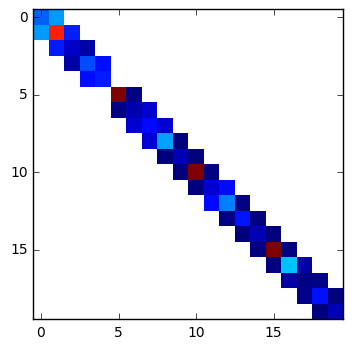

In [415]:
imshow_zero_nan(T)

In [420]:
np.linalg.eigh(M)[0].round(2)

array([-0.  ,  0.29,  0.88,  1.96,  6.05])

In [416]:
np.linalg.eigh(T)[0].round(2)

array([-0.  ,  0.  ,  0.  ,  0.  ,  0.29,  0.29,  0.29,  0.29,  0.88,
        0.88,  0.88,  0.88,  1.96,  1.96,  1.96,  1.96,  6.05,  6.05,
        6.05,  6.05])